In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/PSA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,146.580002,146.580002,144.800003,146.089996,113.703110,636300
1,1/3/2013,145.990005,146.960007,145.300003,145.550003,113.282799,568600
2,1/4/2013,145.410004,146.410004,145.169998,146.220001,113.804298,444100
3,1/7/2013,145.850006,146.630005,145.679993,145.949997,113.594132,442300
4,1/8/2013,145.880005,146.020004,144.350006,144.960007,112.823608,446000


In [3]:
from collections import deque
import random

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate):
        self.X = tf.placeholder(tf.float32, (None, input_size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        feed_forward = tf.layers.dense(self.X, layer_size, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, output_size)
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self):
        for i in range(len(self.trainable)//2):
            assign_op = self.trainable[i+len(self.trainable)//2].assign(self.trainable[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.predict(states)
        Q_new = self.predict(new_states)
        Q_new_negative = self.sess.run(self.model_negative.logits, feed_dict={self.model_negative.X:new_states})
        replay_size = len(replay)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, done_r = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not done_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
        return X, Y

    def predict(self, inputs):
        return self.sess.run(self.model.logits, feed_dict={self.model.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign()
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                state = next_state
                X, Y = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: -148.600191.3, cost: 0.395250, total money: 1565.769743
epoch: 20, total rewards: 145.270202.3, cost: 0.056725, total money: 9723.790207
epoch: 30, total rewards: 634.429916.3, cost: 0.020473, total money: 9790.069915
epoch: 40, total rewards: 202.880096.3, cost: 0.074050, total money: 10202.880096
epoch: 50, total rewards: -152.119904.3, cost: 0.032410, total money: 8386.920089
epoch: 60, total rewards: -66.409898.3, cost: 0.281811, total money: 9933.590102
epoch: 70, total rewards: -167.850021.3, cost: 0.010898, total money: 9620.509980
epoch: 80, total rewards: -90.420029.3, cost: 0.083449, total money: 9909.579971
epoch: 90, total rewards: 323.260421.3, cost: 0.297456, total money: 10323.260421
epoch: 100, total rewards: 347.669891.3, cost: 0.012070, total money: 10347.669892
epoch:

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 146.089996, total balance 9853.910004
day 1, sell 1 unit at price 145.550003, investment -0.369631 %, total balance 9999.460007,
day 3: buy 1 unit at price 145.949997, total balance 9853.510010
day 4, sell 1 unit at price 144.960007, investment -0.678308 %, total balance 9998.470017,
day 18: buy 1 unit at price 154.220001, total balance 9844.250015
day 19, sell 1 unit at price 153.820007, investment -0.259366 %, total balance 9998.070023,
day 23: buy 1 unit at price 156.940002, total balance 9841.130020
day 24, sell 1 unit at price 157.020004, investment 0.050976 %, total balance 9998.150025,
day 26: buy 1 unit at price 157.399994, total balance 9840.750031
day 27, sell 1 unit at price 156.850006, investment -0.349420 %, total balance 9997.600037,
day 30: buy 1 unit at price 154.199997, total balance 9843.400040
day 31, sell 1 unit at price 151.259995, investment -1.906616 %, total balance 9994.660034,
day 37: buy 1 unit at price 151.139999, total balance 984

day 540, sell 1 unit at price 198.279999, investment -1.358139 %, total balance 9796.730011,
day 541, sell 1 unit at price 196.759995, investment -0.876577 %, total balance 9993.490006,
day 559: buy 1 unit at price 199.380005, total balance 9794.110001
day 560, sell 1 unit at price 196.830002, investment -1.278966 %, total balance 9990.940002,
day 562: buy 1 unit at price 197.479996, total balance 9793.460007
day 563, sell 1 unit at price 199.190002, investment 0.865914 %, total balance 9992.650009,
day 571: buy 1 unit at price 193.690002, total balance 9798.960007
day 572: buy 1 unit at price 191.449997, total balance 9607.510010
day 573: buy 1 unit at price 192.070007, total balance 9415.440003
day 574, sell 1 unit at price 190.949997, investment -1.414634 %, total balance 9606.389999,
day 576: buy 1 unit at price 190.070007, total balance 9416.319992
day 577, sell 1 unit at price 191.589996, investment 0.073126 %, total balance 9607.909988,
day 579, sell 1 unit at price 192.809998, 

day 1168: buy 1 unit at price 201.589996, total balance 9817.670120
day 1169, sell 1 unit at price 205.419998, investment 1.899897 %, total balance 10023.090118,
day 1172: buy 1 unit at price 204.300003, total balance 9818.790115
day 1173, sell 1 unit at price 205.570007, investment 0.621637 %, total balance 10024.360123,
day 1184: buy 1 unit at price 212.559998, total balance 9811.800125
day 1185, sell 1 unit at price 214.149994, investment 0.748022 %, total balance 10025.950119,
day 1192: buy 1 unit at price 214.130005, total balance 9811.820114
day 1193, sell 1 unit at price 211.979996, investment -1.004067 %, total balance 10023.800110,
day 1194: buy 1 unit at price 212.750000, total balance 9811.050110
day 1195, sell 1 unit at price 213.990005, investment 0.582846 %, total balance 10025.040115,
day 1198: buy 1 unit at price 213.869995, total balance 9811.170120
day 1199: buy 1 unit at price 213.679993, total balance 9597.490127
day 1200, sell 1 unit at price 213.419998, investment

day 1586: buy 1 unit at price 216.000000, total balance 9807.200119
day 1587, sell 1 unit at price 218.220001, investment 1.027778 %, total balance 10025.420120,
day 1595: buy 1 unit at price 226.820007, total balance 9798.600112
day 1596, sell 1 unit at price 222.630005, investment -1.847281 %, total balance 10021.230117,
day 1606: buy 1 unit at price 230.929993, total balance 9790.300125
day 1607, sell 1 unit at price 231.759995, investment 0.359417 %, total balance 10022.060119,
day 1608: buy 1 unit at price 234.429993, total balance 9787.630126
day 1609, sell 1 unit at price 236.229996, investment 0.767821 %, total balance 10023.860122,
day 1614: buy 1 unit at price 239.940002, total balance 9783.920120
day 1616, sell 1 unit at price 244.889999, investment 2.063014 %, total balance 10028.810119,
day 1619: buy 1 unit at price 243.720001, total balance 9785.090118
day 1620, sell 1 unit at price 240.850006, investment -1.177579 %, total balance 10025.940124,
day 1639: buy 1 unit at pr

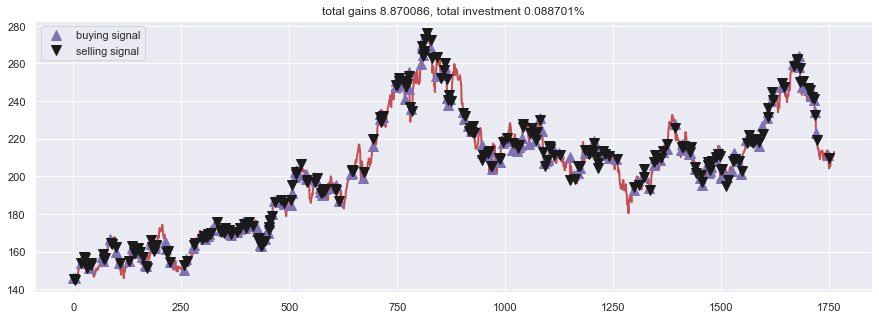

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()